## Importing Packages

In [1]:
"""
Importing (using/include) packages and files needed for the code to run

Topo.jl --- Topography Setup

Note: that we import pyplot last to avoid a name conflict with grid
"""

using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Statistics
using Dates
include("Grid.jl")
include("Markers.jl")
include("Stokes.jl")
include("Temperature.jl")
include("GridOperations.jl")
# Note: that we import pyplot last to avoid a name conflict with grid
using PyPlot
include("Visualization.jl")

plots (generic function with 1 method)

# Material Setup

In [2]:
function ice_viscosity(T::Float64)
    Q = 40000.0 # Activation Enegry (J/mol)
    R_cont = 8.314 # Gas Constant (J/mol*K)
    ice_vis = (1e15)*exp((Q*(273.0-T))/(R_cont*(273.0*T)))
    upperlimit = 1e25
    lowerlimit = 1e12
    if ice_vis < lowerlimit
        ice_vis = lowerlimit
    elseif ice_vis > upperlimit
        ice_vis = upperlimit
    else 
        ice_vis = ice_vis
    end 
    return ice_vis
end

struct Materials
    # 1 - subsurface global ocean
    # 2 - icy shell
    # 3 - sticky air
    alpha::Vector{Float64} # Thermal expansion (1/K)
    rho0::Vector{Float64} # Density (kg/m^3)
    Hr::Vector{Float64} # Radiogenic heat production (W/m^3)
    Cp::Vector{Float64} # Heat capacity (J/kg*K)
    kThermal::Vector{Float64} # Thermal conductivity (W/m*K)
    eta::Vector{Float64} # Viscosity (Pa*s)
    function Materials()
        new([0.0,0.0,0.0],[1000.0,920.0,1.0],[0.0,0.0,0.0],[4180.0,2100.0,1.0e6],[0.5610,2.1,0.024],[1e12,1e15,1e17])
    end    
end

function update_marker_prop!(markers::Markers,materials::Materials)
    eta = markers.scalarFields["eta"]
    rho = markers.scalarFields["rho"]
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark
        markers.scalars[rho,i] = materials.rho0[mmat[i]]
        if mmat[i] == 2
            markers.scalars[eta,i] = ice_viscosity(markers.scalars[T,i])
        end
    end
end

function update_marker_temp!(markers::Markers,materials::Materials)
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark
        if mmat[i] == 1 
            markers.scalars[T,i] = 273.0
        elseif mmat[i] == 3 
            markers.scalars[T,i] = 100.0
        end 
    end 
end 

function initial_conditions!(markers::Markers,materials::Materials,options::Dict)
    material = markers.integerFields["material"]
    T = markers.scalarFields["T"]
    eta = markers.scalarFields["eta"]
    alpha = markers.scalarFields["alpha"]
    Cp = markers.scalarFields["Cp"]
    Hr = markers.scalarFields["Hr"]
    kThermal = markers.scalarFields["kThermal"]
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        hice = initial_ice_depth(mx,options["ice thickness"],options["wavelength"],options["amplitude"],options["surface depth"])
        hsurf = options["surface depth"]
        if my > hice
            # subsurface global ocean
            markers.integers[material,i] = 1
            markers.scalars[T,i] = 273.0
            markers.scalars[eta,i] = materials.eta[1]
            markers.scalars[alpha,i] = materials.alpha[1]        
            markers.scalars[Cp,i] = materials.Cp[1]
            markers.scalars[Hr,i] = materials.Hr[1] 
            markers.scalars[kThermal,i] = materials.kThermal[1]
        elseif my > hsurf
            # icy shell
            markers.integers[material,i] = 2
            markers.scalars[T,i] = 100.0+((273.0-100.0)/(hice-hsurf))*(my-hsurf)
            # markers.scalars[eta,i] = eta_i[i]
            markers.scalars[alpha,i] = materials.alpha[2]
            markers.scalars[Cp,i] = materials.Cp[2]
            markers.scalars[Hr,i] = materials.Hr[2]
            markers.scalars[kThermal,i] = materials.kThermal[2]
        else
            # sticky air
            markers.integers[material,i] = 3
            markers.scalars[T,i] = 100.0            
            markers.scalars[eta,i] = materials.eta[3]
            markers.scalars[alpha,i] = materials.alpha[3]  
            markers.scalars[Cp,i] = materials.Cp[3]
            markers.scalars[Hr,i] = materials.Hr[3]
            markers.scalars[kThermal,i] = materials.kThermal[3]
        end
    end 
    # end loop over markers
    update_marker_prop!(markers,materials)
end

function get_interface(grid::CartesianGrid,mat::Matrix{Float64},contour_value::Float64)
    # Finding interfaces 
    interface_position = zeros(Float64,grid.nx+1);
    for j in 1:grid.nx+1
        i = 1
        while i <= grid.ny
            if mat[i,j] == contour_value
                interface_position[j] = grid.yc[i]
                break
            elseif mat[i+1,j] < contour_value
                # interface is located within this cell.
                interface_position[j] = grid.yc[i] + (grid.yc[i+1]-grid.yc[i])/(mat[i+1,j]-mat[i,j])*(contour_value-mat[i,j])
                break
            end
            i = i+1
        end
    end
    return interface_position
end

include("Topo.jl")
include("TopoInfo.jl")
include("FittingData.jl")

fitting_data (generic function with 1 method)

# Model Setup

In [3]:
# options = Dict()
# options["surface depth"] = 1e4
# options["ice thickness"] = 1e4
# options["wavelength"] = 1e4
# options["amplitude"] = 1e3

function run(options::Dict)
    W = options["wavelength"]
    H = options["ice thickness"] + options["surface depth"] + options["amplitude"] + 1e4
    ny = 151
    nx = Int64(ceil(W/H*ny))
        
    gx = 0.0
    gy = 0.113 


    Tbctype = [-1,-1,1,1] #left, right, top, bottom
#     Tbctype = [1,-1,1,1]
    Tbcval = [0.0,0.0,100.0,273.0] #left, right, top, bottom
#     Tbcval = [273.0,0.0,100.0,273.0]
    bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.
    materials = Materials()

    markx = 6
    marky = 6
    seconds_in_year = 3.15e7
    plot_interval = 1e6*seconds_in_year # plot interval in seconds
    end_time = 3e7*seconds_in_year
    dtmax = plot_interval
    grid = CartesianGrid(W,H,nx,ny)
    println("Creating Markers...")
    @time markers = Markers(grid,["alpha","T","rho","eta","Cp","Hr","kThermal"],["material"] ; nmx=markx,nmy=marky,random=true)
    println("Initial condition...")
    @time initial_conditions!(markers, materials,options)

    local time_plot = []
    local max_topo = []
    local topography = []
    ### Setting up agruments for interface function ###
    # initial 
    i_mat, = marker_to_stag(markers,grid,markers.integers[[markers.integerFields["material"]],:],"center")
    i_air_ice_interface = get_interface(grid,i_mat,2.5)
    i_ocean_ice_interface = get_interface(grid,i_mat,1.5)

    ### Setting up agruments for termination criteria ###
    max_step::Int64=40
    max_time::Float64=-1.0
    max_time = max_time == -1.0 ? typemax(Float64) : max_time
    max_step = max_step == -1 ? typemax(Int64) : max_step

    time = 0.0
    iout= 0
    last_plot = 0.0
    dt = 1e10

    rho_c = nothing
    rho_vx = nothing 
    rho_vy = nothing 
    alpha = nothing 
    Hr = nothing 
    Cp_c = nothing 
    eta_s = nothing 
    eta_n = nothing 
    vxc = nothing 
    vyc = nothing 
    T = nothing 
    dTmax = nothing 
    dTemp = nothing 
    Tnew = nothing 
    Tlast = nothing 
    x_time = nothing
    kThermal = nothing
    ocean_ice_interface = nothing
    mat = nothing

    itime = 1
    output_dir = "test"

    terminate = false
    while !terminate
        # 0. update the markers properties  
        update_marker_prop!(markers,materials)
        update_marker_temp!(markers,materials)
        # 1. Transfer properties markers -> nodes
        # 1a. Basic Nodes
        eta_s_new, = marker_to_stag(markers,grid,["eta",],"basic")
        # 1b. Cell Centers
        rho_c_new,Cp_c_new,alpha_new,eta_n_new,Tlast_new,Hr_new,kThermal_new = marker_to_stag(markers,grid,["rho","Cp","alpha","eta","T","Hr","kThermal"],"center")
        # 1c. Vx and Vy nodes:
        rho_vx_new, = marker_to_stag(markers,grid,["rho",],"vx")
        rho_vy_new, = marker_to_stag(markers,grid,["rho",],"vy") 

        # deal with any NaN values from interpolation:
        if itime > 1
            if any(isnan.(eta_s_new))
                println("found nan values")
            end
            replace_nan!(eta_s,eta_s_new)
            replace_nan!(rho_c,rho_c_new)
            replace_nan!(Hr,Hr_new)
            replace_nan!(Cp_c,Cp_c_new)
            replace_nan!(alpha,alpha_new)
            replace_nan!(eta_n,eta_n_new)
            replace_nan!(Tlast,Tlast_new)
            replace_nan!(rho_vx,rho_vx_new)
            replace_nan!(rho_vy,rho_vy_new)
            replace_nan!(kThermal,kThermal_new)
        end
        # Copy field data 
        kThermal = copy(kThermal_new)
        rho_vx = copy(rho_vx_new)
        rho_vy = copy(rho_vy_new)
        rho_c = copy(rho_c_new)
        Hr = copy(Hr_new)
        Cp_c = copy(Cp_c_new)
        alpha = copy(alpha_new)
        eta_s = copy(eta_s_new)
        eta_n = copy(eta_n_new)
        Tlast = copy(Tlast_new)

        if itime == 1 
            println(Tbctype,Tbcval)
            ghost_temperature_center(grid,Tlast,Tbctype,Tbcval)
            cell_center_to_markers!(markers,grid,Tlast,markers.scalars[[markers.scalarFields["T"],],:])
        else
            ghost_temperature_center(grid,Tlast,Tbctype,Tbcval)
        end

        # 2. Assemble and solve the stokes equations
        L,R = form_stokes(grid,eta_s,eta_n,rho_vx,rho_vy,bc,gx,gy;dt=dt)
        stokes_solution = L\R
        vx,vy,P = unpack(stokes_solution,grid;ghost=true)

        # Get the velocity at the cell centers:
        vxc,vyc = velocity_to_centers(grid,vx,vy)
        adiabatic_heating = compute_adiabatic_heating(grid,rho_c,Tlast,alpha,gx,gy,vxc,vyc)*0.0
        shear_heating = compute_shear_heating(grid,vx,vy,eta_n,eta_s)*0.0
        H = (adiabatic_heating .+ shear_heating .+ Hr).*0.0

        # 3. Compute the advection timestep
        if itime > 1
            this_dtmax = min(1.2*dt,dtmax)
        else
            this_dtmax = dtmax
        end
        dt = compute_timestep(grid,vxc,vyc;dtmax=this_dtmax,cfl=0.25)
        diffusion_timestep = (grid.x[2]-grid.x[1])^2 / 1e-6
        if dt > diffusion_timestep
            dt = diffusion_timestep
        end

        dTmax = Inf
        dTemp = nothing
        Tnew = nothing
        titer = 1
        for titer=1:2
            # assemble and solve the energy equation
            println("Trying with timestep ",dt/seconds_in_year/1e3," kyr")
            L,R = assemble_energy_equation_center(grid,rho_c,Cp_c,kThermal,H,Tlast,dt,Tbctype,Tbcval)
            Tnew = L\R;
            Tnew = reshape(Tnew,grid.ny,grid.nx);
            Tnew = ghost_temperature_center(grid,Tnew,Tbctype,Tbcval)
            T = copy(Tnew)

            dTemp = Tnew-Tlast
            # compute the maximum temperature change
            dTmax = maximum(abs.(dTemp[2:end-1,2:end-1]));
            println("dTmax=",dTmax," dt=",dt/seconds_in_year/1e3," kyr")
            dt = min(dt,dTmax < 10.0 ? dt : dt*10.0/dTmax)
            if dTmax < 10.0
                break
            end
        end

        dT_subgrid_node = subgrid_temperature_relaxation_center!(markers,grid,Tlast,Cp_c[1,1],kThermal[1,1],dt)
        dT_remaining = dTemp - dT_subgrid_node

        cell_center_change_to_markers!(markers,grid,dT_remaining,"T")

        # Checking Termination Criteria, time is in Myr
        if time >= max_time || itime >= max_step
            terminate = true
        end    

#         if time == 0.0 || mod(itime,100) == 0 || true
#             last_plot = time 
#             # Gird output
#             name1 = @sprintf("%s/viz.%04d.vtr",output_dir,iout)
#             println("Writing visualization file = ",name1)
#             vn = velocity_to_basic_nodes(grid,vxc,vyc)
#             visualization(grid,rho_c,eta_s,vn,P,Tnew[2:end-1,2:end-1],time/seconds_in_year;filename=name1)
#             # Markers output
#             name2 = @sprintf("%s/markers.%04d.vtp",output_dir,iout)
#             println("Writing visualization file = ",name2)
#             visualization(markers,time/seconds_in_year;filename=name2)
#             iout += 1
#         end

        # println("Min/Max velocity: ",minimum(vyc)," ",maximum(vyc))            
        # Moving the markers and advancing to the next timestep
        move_markers_rk4!(markers,grid,vx,vy,dt,continuity_weight=1/3)
        time += dt
        itime += 1
        println("Finished Step ",itime," time=",time/seconds_in_year/1e3," kyr")
        x_time = @sprintf("%.3g",time/3.15e7/1e6);
        mat, = marker_to_stag(markers,grid,markers.integers[[markers.integerFields["material"]],:],"center")
        ocean_ice_interface = get_interface(grid,mat,1.5)
        air_ice_interface = get_interface(grid,mat,2.5)
        append!(time_plot,time)
        append!(max_topo,maximum(ocean_ice_interface.-(options["ice thickness"] + options["surface depth"])))
        append!(topography,[ocean_ice_interface])
    end
    return grid,i_mat,mat,time_plot,topography,time,max_topo,max_step
end

# grid,i_mat,mat,times,topography,time,max_topo = run(options)


# air_ice_interface = get_interface(grid,mat,2.5)
# ocean_ice_interface = get_interface(grid,mat,1.5)
# i_air_ice_interface = get_interface(grid,i_mat,2.5)
# i_ocean_ice_interface = get_interface(grid,i_mat,1.5)

# figure()
# scatter(markers.x[1,:],markers.x[2,:],c="b",s=0.1)
# show()

run (generic function with 1 method)

In [4]:
# wavelength = [1e4,2e4,3e4,4e4,5e4,6e4,7e4,8e4,9e4]
# function short_wavelength_model_run(wavelength::Vector{Float64})
#     for i in range(start=1,step=1,stop=length(wavelength))
#         options = Dict()
#         options["surface depth"] = 1e4
#         options["ice thickness"] = 1e4
#         options["wavelength"] = wavelength[i]
#         options["amplitude"] = 1e3
#         grid,i_mat,mat,times,topography,time,max_topo,max_step = run(options);
#         air_ice_interface = get_interface(grid,mat,2.5);
#         ocean_ice_interface = get_interface(grid,mat,1.5);
#         i_air_ice_interface = get_interface(grid,i_mat,2.5);
#         i_ocean_ice_interface = get_interface(grid,i_mat,1.5);
#         fitting_data(topography,times,max_step)
#         println(get_time_viscous(wavelength[i]))
#     end
# end

In [5]:
num_exp = []
half_space = []

Any[]

In [6]:
function wavelength_model_run(wavelength::Float64)
    options = Dict()
    options["surface depth"] = 1e4
    options["ice thickness"] = 1e4
    options["wavelength"] = wavelength
    options["amplitude"] = 1e3
    grid,i_mat,mat,times,topography,time,max_topo,max_step = run(options);
    air_ice_interface = get_interface(grid,mat,2.5);
    ocean_ice_interface = get_interface(grid,mat,1.5);
    i_air_ice_interface = get_interface(grid,i_mat,2.5);
    i_ocean_ice_interface = get_interface(grid,i_mat,1.5);
    fitting_data(topography,times,max_step)
    ths = get_time_viscous(wavelength) 
    tvis = get_numerical_time_viscous(i_air_ice_interface,i_ocean_ice_interface,air_ice_interface,ocean_ice_interface,time)
    return ths,tvis
end

wavelength_model_run (generic function with 1 method)

Creating Markers...
  0.070425 seconds (19 allocations: 243.609 MiB)
Initial condition...
  1.349814 seconds (18.61 M allocations: 289.446 MiB, 5.39% gc time)
[-1, -1, 1, 1][0.0, 0.0, 100.0, 273.0]
Trying with timestep 1.3403747687853524 kyr
dTmax=1.2988799946912195 dt=1.3403747687853524 kyr
Finished Step 2 time=1.3403747687853524 kyr
Trying with timestep 1.3403747687853524 kyr
dTmax=1.1956129709438414 dt=1.3403747687853524 kyr
Finished Step 3 time=2.680749537570705 kyr
Trying with timestep 1.3403747687853524 kyr
dTmax=1.214137657269589 dt=1.3403747687853524 kyr
Finished Step 4 time=4.021124306356057 kyr
Trying with timestep 1.3403747687853524 kyr
dTmax=1.234544906282565 dt=1.3403747687853524 kyr
Finished Step 5 time=5.36149907514141 kyr
Trying with timestep 1.3403747687853524 kyr
dTmax=1.2702858230185257 dt=1.3403747687853524 kyr
Finished Step 6 time=6.701873843926761 kyr
Trying with timestep 1.3403747687853524 kyr
dTmax=1.3003993025333216 dt=1.3403747687853524 kyr
Finished Step 7 tim

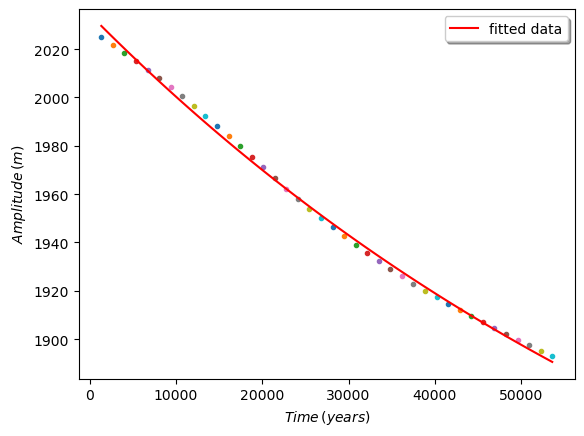

(490.3298923990251, 506205.1425263054)

In [39]:
wavelength = 9e4
test_run = wavelength_model_run(wavelength)

In [40]:
push!(num_exp,[test_run[2],wavelength])

9-element Vector{Any}:
 [46055.749471694515, 10000.0]
 [91870.56548193262, 20000.0]
 [139862.28378207257, 30000.0]
 [191148.86886866705, 40000.0]
 [279998.5565796999, 50000.0]
 [335814.7418338761, 60000.0]
 [401535.5331473103, 70000.0]
 [450742.34073933406, 80000.0]
 [506205.1425263054, 90000.0]

In [41]:
push!(half_space,test_run[1])

9-element Vector{Any}:
 4412.969031591225
 2206.4845157956124
 1470.9896771970753
 1103.2422578978062
  882.5938063182451
  735.4948385985376
  630.4241473701751
  551.6211289489031
  490.3298923990251

In [42]:
display(num_exp)
display(half_space)

9-element Vector{Any}:
 [46055.749471694515, 10000.0]
 [91870.56548193262, 20000.0]
 [139862.28378207257, 30000.0]
 [191148.86886866705, 40000.0]
 [279998.5565796999, 50000.0]
 [335814.7418338761, 60000.0]
 [401535.5331473103, 70000.0]
 [450742.34073933406, 80000.0]
 [506205.1425263054, 90000.0]

9-element Vector{Any}:
 4412.969031591225
 2206.4845157956124
 1470.9896771970753
 1103.2422578978062
  882.5938063182451
  735.4948385985376
  630.4241473701751
  551.6211289489031
  490.3298923990251

In [43]:
num_exp = vcat(map(x->x',num_exp)...)

9×2 Matrix{Float64}:
 46055.7        10000.0
 91870.6        20000.0
     1.39862e5  30000.0
     1.91149e5  40000.0
     2.79999e5  50000.0
     3.35815e5  60000.0
     4.01536e5  70000.0
     4.50742e5  80000.0
     5.06205e5  90000.0

In [44]:
using DataFrames
df = DataFrame(lambda = num_exp[:,2], numerical_time = num_exp[:,1], halfspace_time = half_space)

Row,lambda,numerical_time,halfspace_time
,Float64,Float64,Any
1,10000.0,46055.7,4412.97
2,20000.0,91870.6,2206.48
3,30000.0,1.39862e5,1470.99
4,40000.0,1.91149e5,1103.24
5,50000.0,2.79999e5,882.594
6,60000.0,3.35815e5,735.495
7,70000.0,4.01536e5,630.424
8,80000.0,4.50742e5,551.621
9,90000.0,5.06205e5,490.33


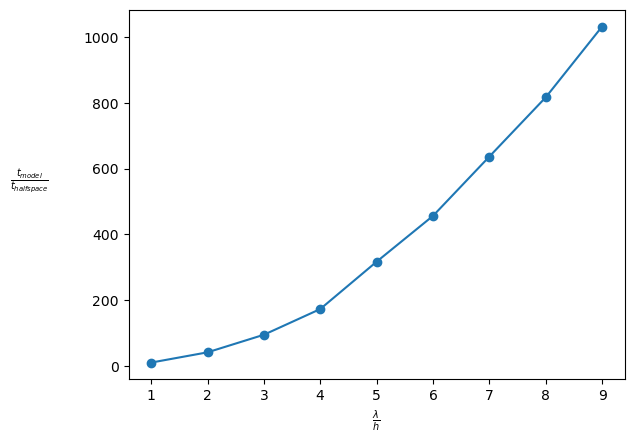

In [45]:
figure()
plot(df.lambda./1e4,df.numerical_time./df.halfspace_time,"-o")
gca().set_xlabel(L"\frac{\lambda}{h}")
gca().set_ylabel(L"\frac{t_{model}}{t_{halfspace}}",rotation=0)
gca().yaxis.set_label_coords(-0.2,0.5)
show()

In [2]:
46055.7/4412.97

10.43644076438317